In [1]:
%matplotlib nbagg
#Import required libraries
# from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
# from drawnow import drawnow, figure
from scipy import stats
from scipy.signal import butter, lfilter, freqz, filtfilt
import pandas as pd
import math
from matplotlib import rcParams
import copy
rcParams.update({'figure.autolayout': True})

# Functions

In [19]:
def butter_filter(data, cutoff, order, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff)  # , btype='low', analog=False
#     b, a = butter(3, 0.1)
    y = filtfilt(b, a, data)
    return y

def get_rolling_slope(csv_data):
    window_width_raw = 40
    window_width_flowrate = 10
    cutoff_1 = 0.03
    order_1 = 3  # 6 # 12
    datapnt_delay = 163
    fps = 1000/datapnt_delay
 
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
            curr_window_raw = raw_data[int(-window_width_raw*fps):]
            curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            x =list(range(len(curr_window_raw_filtered)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
            #print('curr_slope:', curr_slope)
            
            #Convert light results
            syringe_rad = 21.7/2 #Syringe radius in mm
            syringe_area = math.pi*(syringe_rad ** 2)
            conversion_factor = 0.06*fps
            curr_flowrate = curr_slope*syringe_area*conversion_factor
            flow_rate.append(curr_flowrate)
        else:
            flow_rate.append(0)
                
        cutoff_2 = 0.6
        order_2 = 6
        if len(flow_rate) > (window_width_raw+window_width_flowrate)*fps:
            curr_start = int(-window_width_flowrate*fps)
            curr_window_flowrate = flow_rate[curr_start:]
            
#             curr_window_flowrate_filtered = butter_filter(curr_window_flowrate, cutoff_2, order_2, fps)[0]
            curr_window_flowrate_filtered = np.mean(curr_window_flowrate)
            flow_rate_filtered.append(curr_window_flowrate_filtered)

        else:
            flow_rate_filtered.append(0)
    return flow_rate_filtered
#     return flow_rate

def get_rolling_slope_measured(csv_data,time):
    #Sampled every 5 seconds - real data
    fps = 1
    window_width = 3
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    density_milk = 1 
    conversion_factor = 60
    time_interval = 5 #5s between data recordings
    flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    data_mean, data_std = np.mean(flow_rate), np.std(flow_rate)
    # identify outliers
    cut_off = data_std * 0.7
    lower, upper = data_mean - cut_off, data_mean + cut_off
    indexes_to_remove = np.where((flow_rate< lower) | (flow_rate > upper))[0]
  
    flow_rate_filtered = np.delete(flow_rate, indexes_to_remove)#indexes_to_remove[0])
    time_filtered = np.delete(np.array(time),indexes_to_remove)
        
    return flow_rate_filtered,time_filtered



def get_time(csv_data):

    datapnt_delay = 163
    fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time


def process_csv(csv_path):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    return csv_data


# Read Data In

In [20]:
# Path to folder containing sensor data (csv file format)
#csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'
csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-16 Light Testing'
# csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'
#csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\2022-02-16 Light Testing'

#Read sensor data
# csv_name_15_light1 = r'light_15ml_1.csv'
# csv_name_15_light2 = r'light_15ml_2.csv'
# csv_name_15_light3 = r'light_15ml_3.csv'
# csv_name_15_light4 = r'light_15ml_4.csv'
csv_name_30_light1 = r'light_30ml_1.csv'
csv_name_30_light2 = r'light_30ml_2.csv'
csv_name_30_light3 = r'light_30ml_3.csv'
csv_name_30_light4 = r'light_30ml_4.csv'
csv_name_30_light5 = r'light_30ml_5.csv'

# csv_path_15_light1 = os.path.join(csv_data_folder, csv_name_15_light1)
# csv_path_15_light2 = os.path.join(csv_data_folder, csv_name_15_light2)
# csv_path_15_light3 = os.path.join(csv_data_folder, csv_name_15_light3)
# csv_path_15_light4 = os.path.join(csv_data_folder, csv_name_15_light4)
csv_path_30_light1 = os.path.join(csv_data_folder, csv_name_30_light1)
csv_path_30_light2 = os.path.join(csv_data_folder, csv_name_30_light2)
csv_path_30_light3 = os.path.join(csv_data_folder, csv_name_30_light3)
csv_path_30_light4 = os.path.join(csv_data_folder, csv_name_30_light4)
csv_path_30_light5 = os.path.join(csv_data_folder, csv_name_30_light5)

# csv_data_15_light1 = process_csv(csv_path_15_light1)
# csv_data_15_light2 = process_csv(csv_path_15_light2)
# csv_data_15_light3 = process_csv(csv_path_15_light3)
# csv_data_15_light4 = process_csv(csv_path_15_light4)
csv_data_30_light1 = process_csv(csv_path_30_light1)[303:]
csv_data_30_light2 = process_csv(csv_path_30_light2)[244:]
csv_data_30_light3 = process_csv(csv_path_30_light3)[707:]
csv_data_30_light4 = process_csv(csv_path_30_light4)[364:]
csv_data_30_light5 = process_csv(csv_path_30_light5)[317:]

# time_15_light1 = get_time(csv_data_15_light1)
# time_15_light2 = get_time(csv_data_15_light2)
# time_15_light3 = get_time(csv_data_15_light3)
# time_15_light4 = get_time(csv_data_15_light4)
time_30_light1 = get_time(csv_data_30_light1)
time_30_light2 = get_time(csv_data_30_light2)
time_30_light3 = get_time(csv_data_30_light3)
time_30_light4 = get_time(csv_data_30_light4)
time_30_light5 = get_time(csv_data_30_light5)
#Read real sensor data
# csv_name_15_light_measured = r'real_light_15ml.csv'
# csv_path_15_light_measured = os.path.join(csv_data_folder, csv_name_15_light_measured)
# csv_data_15_light_measured = pd.read_csv(csv_path_15_light_measured)

csv_name_30_light_measured = r'real_light_30ml.csv'
csv_path_30_light_measured = os.path.join(csv_data_folder, csv_name_30_light_measured)
csv_data_30_light_measured = pd.read_csv(csv_path_30_light_measured)

# time_15_light_measured1 = csv_data_15_light_measured['Time'][csv_data_15_light_measured['Trial 1'].notna()]
# time_15_light_measured2 = csv_data_15_light_measured['Time'][csv_data_15_light_measured['Trial 2'].notna()]
# time_15_light_measured3 = csv_data_15_light_measured['Time'][csv_data_15_light_measured['Trial 3'].notna()]
# time_15_light_measured4 = csv_data_15_light_measured['Time'][csv_data_15_light_measured['Trial 4'].notna()]

time_30_light_measured1 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 1'].notna()]
time_30_light_measured2 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 2'].notna()]
time_30_light_measured3 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 3'].notna()]
time_30_light_measured4 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 4'].notna()]
time_30_light_measured5 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 5'].notna()]

# csv_data_15_light_measured1 = csv_data_15_light_measured['Trial 1'].dropna()
# csv_data_15_light_measured2 = csv_data_15_light_measured['Trial 2'].dropna()
# csv_data_15_light_measured3 = csv_data_15_light_measured['Trial 3'].dropna()
# csv_data_15_light_measured4 = csv_data_15_light_measured['Trial 4'].dropna()

csv_data_30_light_measured1 = csv_data_30_light_measured['Trial 1'].dropna()
csv_data_30_light_measured2 = csv_data_30_light_measured['Trial 2'].dropna()
csv_data_30_light_measured3 = csv_data_30_light_measured['Trial 3'].dropna()
csv_data_30_light_measured4 = csv_data_30_light_measured['Trial 4'].dropna()
csv_data_30_light_measured5 = csv_data_30_light_measured['Trial 5'].dropna()

# Light Sensor Raw Data Comparison 15 mL

<IPython.core.display.Javascript object>


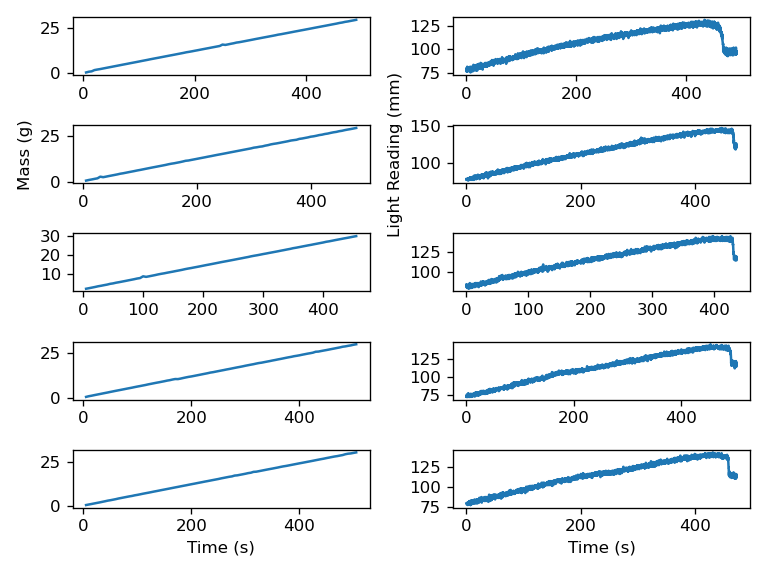

Text(0.5, 0, 'Time (s)')

In [21]:
#Read sensor data
fig, axs = plt.subplots(5,2)

axs[0,0].plot(time_30_light_measured1,csv_data_30_light_measured1)
axs[0,1].plot(time_30_light1,csv_data_30_light1)

axs[1,0].plot(time_30_light_measured2,csv_data_30_light_measured2)
axs[1,0].set_ylabel('Mass (g)')
axs[1,1].plot(time_30_light2,csv_data_30_light2)
axs[1,1].set_ylabel('Light Reading (mm)')

axs[2,0].plot(time_30_light_measured3,csv_data_30_light_measured3)
axs[2,1].plot(time_30_light3,csv_data_30_light3)

axs[3,0].plot(time_30_light_measured4,csv_data_30_light_measured4)
axs[3,1].plot(time_30_light4,csv_data_30_light4)

axs[4,0].plot(time_30_light_measured5,csv_data_30_light_measured5)
axs[4,0].set_xlabel('Time (s)')
axs[4,1].plot(time_30_light5,csv_data_30_light5)
axs[4,1].set_xlabel('Time (s)')


# Light Sensor Slope Data Comparison

<IPython.core.display.Javascript object>


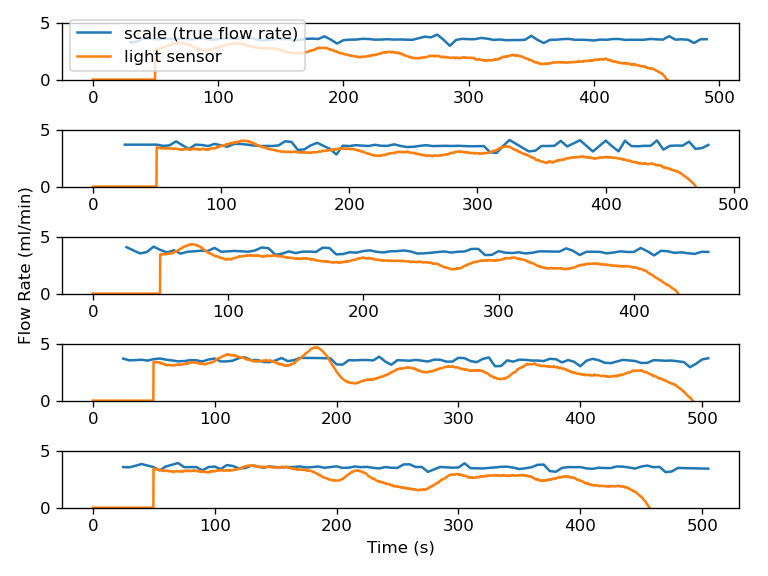

Text(0.5, 0, 'Time (s)')

In [22]:
fig, axs_2 = plt.subplots(5)
flow_rate_light1 = get_rolling_slope(csv_data_30_light1)
flow_rate_light2 = get_rolling_slope(csv_data_30_light2)
flow_rate_light3 = get_rolling_slope(csv_data_30_light3)
flow_rate_light4 = get_rolling_slope(csv_data_30_light4)
flow_rate_light5 = get_rolling_slope(csv_data_30_light5)


flow_rate_light_measured1,time_light_measured1_filt =get_rolling_slope_measured(csv_data_30_light_measured1,time_30_light_measured1)
flow_rate_light_measured2,time_light_measured2_filt =get_rolling_slope_measured(csv_data_30_light_measured2,time_30_light_measured2)
flow_rate_light_measured3,time_light_measured3_filt =get_rolling_slope_measured(csv_data_30_light_measured3,time_30_light_measured3)
flow_rate_light_measured4,time_light_measured4_filt =get_rolling_slope_measured(csv_data_30_light_measured4,time_30_light_measured4)
flow_rate_light_measured5,time_light_measured5_filt =get_rolling_slope_measured(csv_data_30_light_measured5,time_30_light_measured5)


y_lim = [0,5]
axs_2[0].plot(time_light_measured1_filt,flow_rate_light_measured1, label='scale (true flow rate)')
axs_2[0].plot(time_30_light1,flow_rate_light1, label='light sensor')
axs_2[0].set_ylim(y_lim)
axs_2[0].legend()

axs_2[1].plot(time_light_measured2_filt,flow_rate_light_measured2)
axs_2[1].plot(time_30_light2,flow_rate_light2)  # time_light2
axs_2[1].set_ylim(y_lim)

axs_2[2].plot(time_light_measured3_filt,flow_rate_light_measured3)
axs_2[2].plot(time_30_light3,flow_rate_light3) # time_light3
axs_2[2].set_ylim(y_lim)
axs_2[2].set_ylabel('Flow Rate (ml/min)')

axs_2[3].plot(time_light_measured4_filt,flow_rate_light_measured4)
axs_2[3].plot(time_30_light4,flow_rate_light4) # time_light4
axs_2[3].set_ylim(y_lim)

axs_2[4].plot(time_light_measured5_filt,flow_rate_light_measured5)
axs_2[4].plot(time_30_light5,flow_rate_light5) # time_light4
axs_2[4].set_ylim(y_lim)
axs_2[4].set_xlabel('Time (s)')